In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import GlobalAveragePooling2D,Dropout,BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

In [2]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.3)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateModel1(noOfClasses):
    modelInput = tf.keras.applications.EfficientNetB0(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(modelInput.output)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)
    
    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.EfficientNetB0(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
    ]
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=METRICS)
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'EfficientNetB0.keras', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [6]:
def modelFit(model, annealer, checkpoint):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=gEpochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [7]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [8]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[7]*100
    TP = evl[1]
    FP = evl[2]
    FN = evl[4]
    TN = evl[3]
    prec = evl[5]
    rec = evl[6]
    F1 = 100 * ((2 * prec * rec) / (prec + rec))
    auc = evl[8]
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    msg+=f'\nTrue Positives = {TP}. True Negatives = {TN}'
    msg+=f'\nFalse Positives = {FP}. False Negatives = {FN}'
    msg+=f'\nPrecision = {prec}'
    msg+=f'\nRecall = {rec}'
    msg+=f'\nF1 Score = {F1}'
    msg+=f'\nROC AUC = {auc}'
    print(msg)
    
def saveModel(model, className):
    save_path = "/kaggle/working/" + className + " - EfficientNetB0.keras"
    model.save(save_path)
    print("Model saved at:", save_path)

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [10]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")
    def objective_function(hyperparameters):
        lr,batch = hyperparameters
        accuracy = accuracy_score(y_true,y_pred)
        return -accuracy
    
    accuracy = accuracy_score(y_true, y_pred)
    search_space = [(1e-4, 1e-2), (32, 256)]
    result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')
    best_hyperparameters = result.x
    print("Best Hyperparameters (learning rate, batch size):", best_hyperparameters)

In [11]:
mpath = r'../input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
batchSize = 64
lr = 0.001

for i in classPaths:
    className = i
    print(className)
    

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normaliza

2024-04-22 09:46:36.514470: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1713779200.885633     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


547/547 [==============================] - ETA: 0s - loss: 0.1709 - tp: 16336.0000 - fp: 806.0000 - tn: 69194.0000 - fn: 1164.0000 - precision: 0.9530 - recall: 0.9335 - accuracy: 0.9417 - auc: 0.9955
Epoch 1: val_loss improved from inf to 0.05647, saving model to Cervical Cancer EfficientNetB0.keras
547/547 [==============================] - 250s 433ms/step - loss: 0.1709 - tp: 16336.0000 - fp: 806.0000 - tn: 69194.0000 - fn: 1164.0000 - precision: 0.9530 - recall: 0.9335 - accuracy: 0.9417 - auc: 0.9955 - val_loss: 0.0565 - val_tp: 7354.0000 - val_fp: 120.0000 - val_tn: 29880.0000 - val_fn: 146.0000 - val_precision: 0.9839 - val_recall: 0.9805 - val_accuracy: 0.9823 - val_auc: 0.9996 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.0497 - tp: 17201.0000 - fp: 248.0000 - tn: 69752.0000 - fn: 299.0000 - precision: 0.9858 - recall: 0.9829 - accuracy: 0.9843 - auc: 0.9997
Epoch 2: val_loss improved from 0.05647 to 0.02334, saving model to Cervical Canc

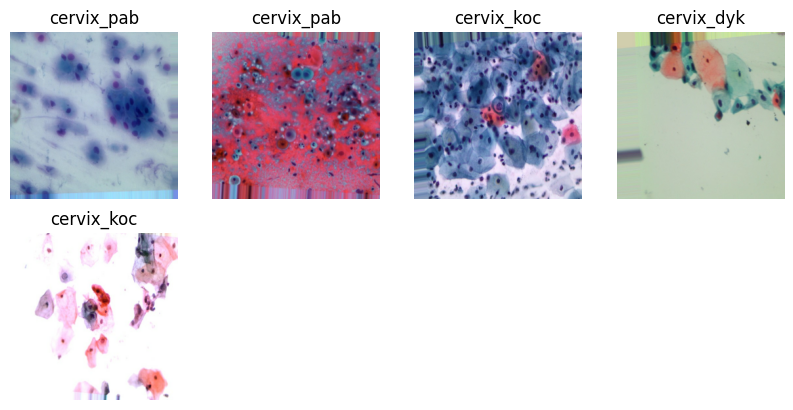

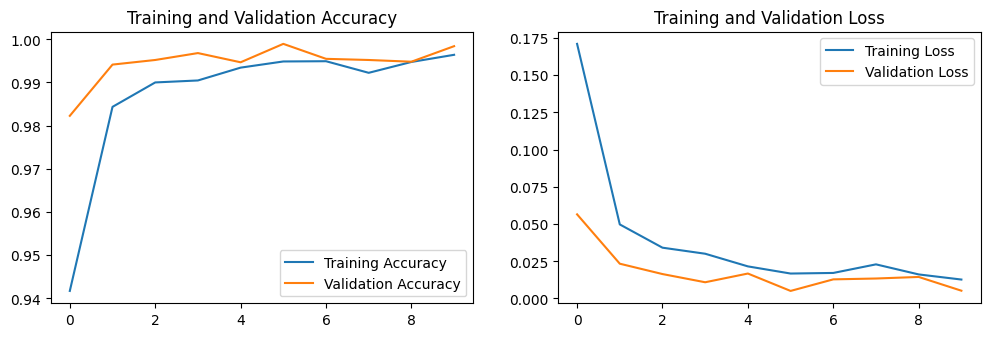

235/235 [==============================] - 22s 95ms/step - loss: 0.0052 - tp: 7488.0000 - fp: 12.0000 - tn: 29988.0000 - fn: 12.0000 - precision: 0.9984 - recall: 0.9984 - accuracy: 0.9984 - auc: 1.0000
Accuracy on the Test Set = 99.84 %
True Positives = 7488.0. True Negatives = 29988.0
False Positives = 12.0. False Negatives = 12.0
Precision = 0.9983999729156494
Recall = 0.9983999729156494
F1 Score = 99.83999729156494
ROC AUC = 0.999995768070221
Model saved at: /kaggle/working/Cervical Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 4 4 4]
235/235 [==============================] - 24s 94ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

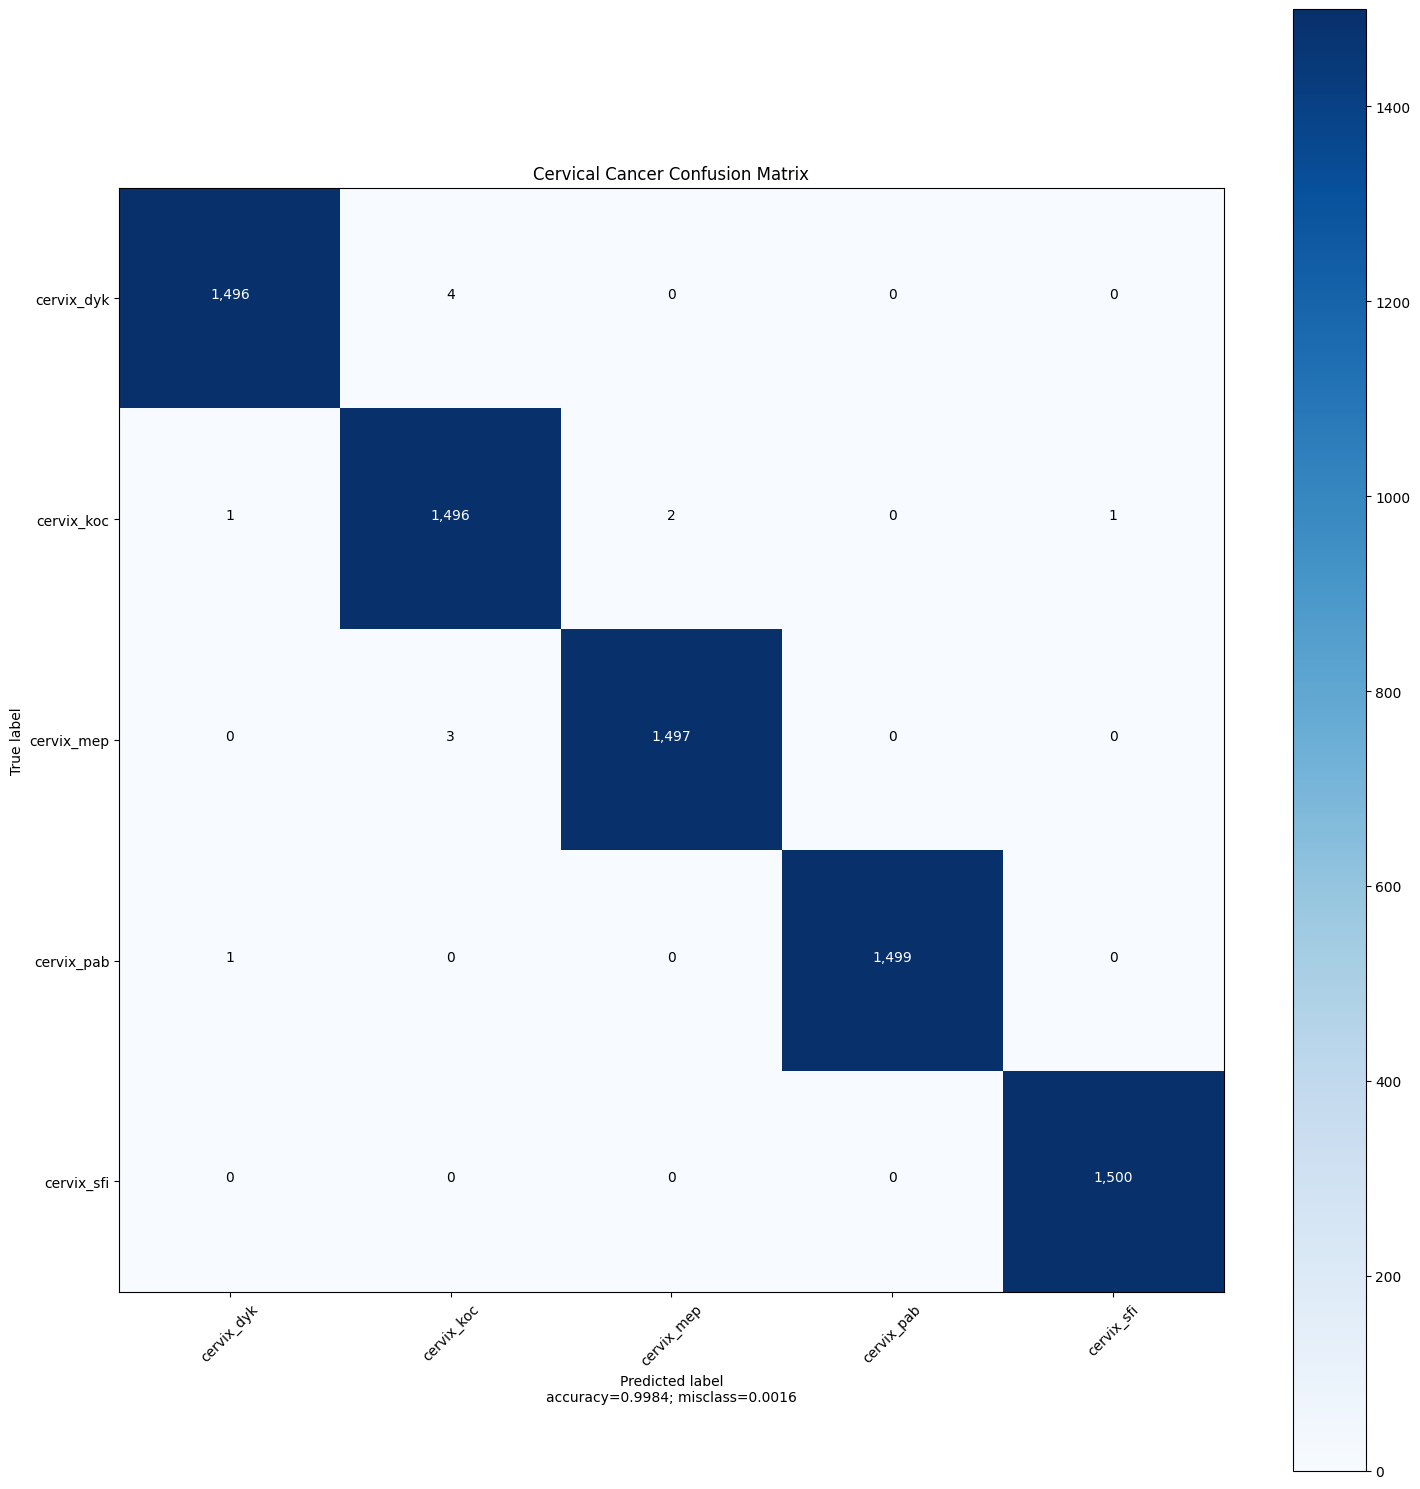

Best Hyperparameters (learning rate, batch size): [9.95284041e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [12]:
className = 'Cervical Cancer '
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Val :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']       

2024-04-22 10:03:26.553136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


547/547 [==============================] - ETA: 0s - loss: 0.0999 - tp: 16840.0000 - fp: 536.0000 - tn: 69464.0000 - fn: 660.0000 - precision: 0.9692 - recall: 0.9623 - accuracy: 0.9655 - auc: 0.9985
Epoch 1: val_loss improved from inf to 0.03646, saving model to Lung And Colon Cancer EfficientNetB0.keras
547/547 [==============================] - 249s 441ms/step - loss: 0.0999 - tp: 16840.0000 - fp: 536.0000 - tn: 69464.0000 - fn: 660.0000 - precision: 0.9692 - recall: 0.9623 - accuracy: 0.9655 - auc: 0.9985 - val_loss: 0.0365 - val_tp: 7409.0000 - val_fp: 86.0000 - val_tn: 29914.0000 - val_fn: 91.0000 - val_precision: 0.9885 - val_recall: 0.9879 - val_accuracy: 0.9884 - val_auc: 0.9998 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.0417 - tp: 17233.0000 - fp: 250.0000 - tn: 69750.0000 - fn: 267.0000 - precision: 0.9857 - recall: 0.9847 - accuracy: 0.9854 - auc: 0.9998
Epoch 2: val_loss did not improve from 0.03646
547/547 [=======================

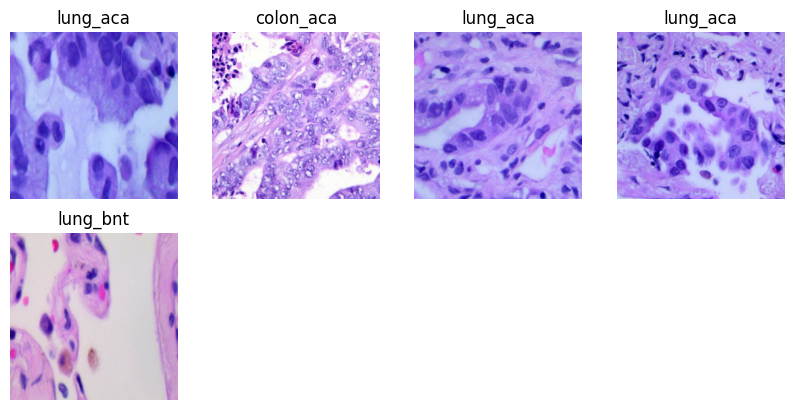

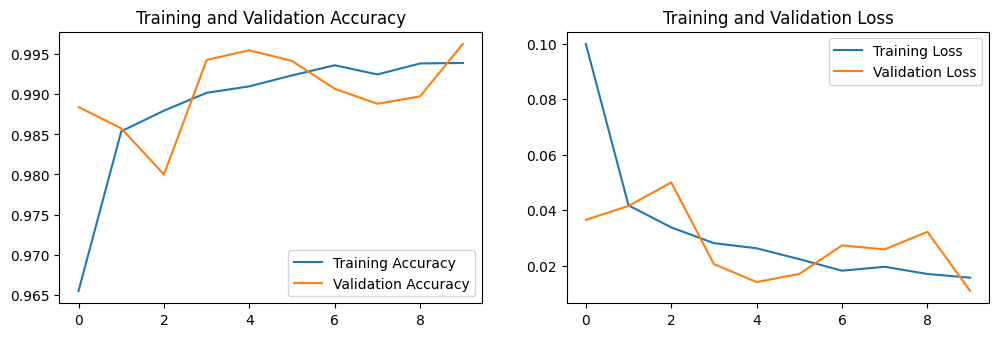

235/235 [==============================] - 25s 107ms/step - loss: 0.0109 - tp: 7472.0000 - fp: 28.0000 - tn: 29972.0000 - fn: 28.0000 - precision: 0.9963 - recall: 0.9963 - accuracy: 0.9963 - auc: 0.9999
Accuracy on the Test Set = 99.63 %
True Positives = 7472.0. True Negatives = 29972.0
False Positives = 28.0. False Negatives = 28.0
Precision = 0.9962666630744934
Recall = 0.9962666630744934
F1 Score = 99.62666630744934
ROC AUC = 0.9998518824577332
Model saved at: /kaggle/working/Lung And Colon Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 4 4 4]
235/235 [==============================] - 25s 102ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

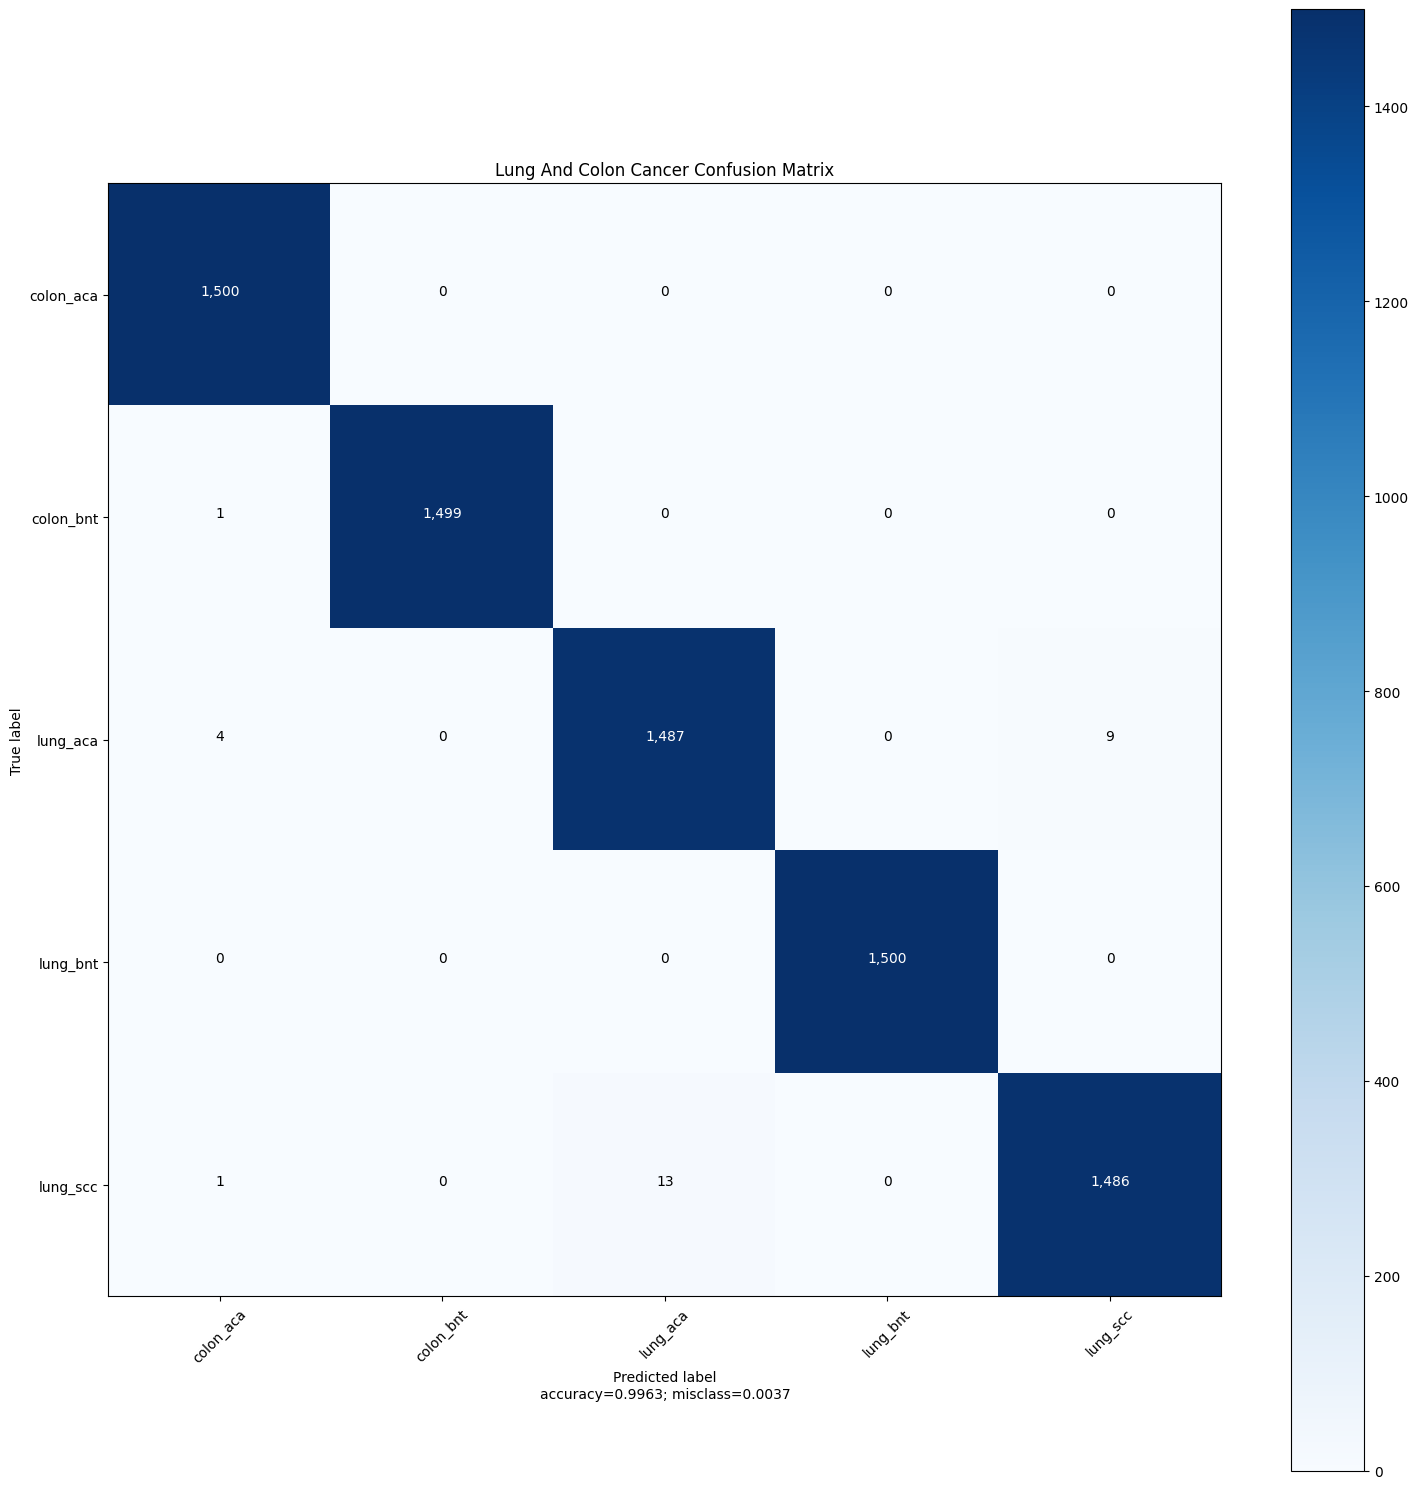

Best Hyperparameters (learning rate, batch size): [9.95284083e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [13]:
className = 'Lung And Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 7002 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         [

2024-04-22 12:39:16.892534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1713789561.119298     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - ETA: 0s - loss: 0.4235 - tp: 5701.0000 - fp: 1301.0000 - tn: 5701.0000 - fn: 1301.0000 - precision: 0.8142 - recall: 0.8142 - accuracy: 0.8142 - auc: 0.8922
Epoch 1: val_loss improved from inf to 0.30260, saving model to Oral Cancer EfficientNetB0.keras
219/219 [==============================] - 102s 411ms/step - loss: 0.4235 - tp: 5701.0000 - fp: 1301.0000 - tn: 5701.0000 - fn: 1301.0000 - precision: 0.8142 - recall: 0.8142 - accuracy: 0.8142 - auc: 0.8922 - val_loss: 0.3026 - val_tp: 2608.0000 - val_fp: 392.0000 - val_tn: 2608.0000 - val_fn: 392.0000 - val_precision: 0.8693 - val_recall: 0.8693 - val_accuracy: 0.8693 - val_auc: 0.9490 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.2716 - tp: 6199.0000 - fp: 803.0000 - tn: 6199.0000 - fn: 803.0000 - precision: 0.8853 - recall: 0.8853 - accuracy: 0.8853 - auc: 0.9554
Epoch 2: val_loss did not improve from 0.30260
219/219 [==============================] - 

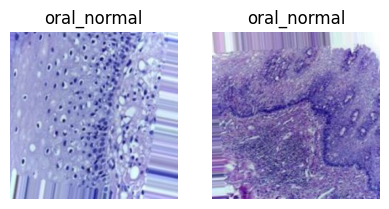

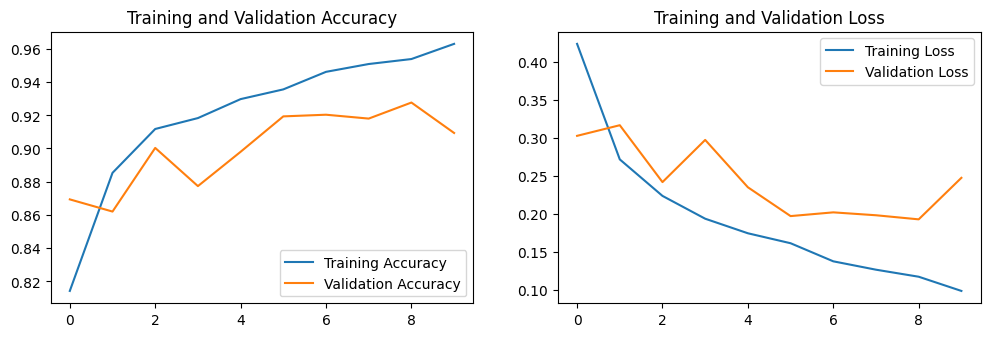

94/94 [==============================] - 10s 103ms/step - loss: 0.2474 - tp: 2728.0000 - fp: 272.0000 - tn: 2728.0000 - fn: 272.0000 - precision: 0.9093 - recall: 0.9093 - accuracy: 0.9093 - auc: 0.9673
Accuracy on the Test Set = 90.93 %
True Positives = 2728.0. True Negatives = 2728.0
False Positives = 272.0. False Negatives = 272.0
Precision = 0.909333348274231
Recall = 0.909333348274231
F1 Score = 90.9333348274231
ROC AUC = 0.9672905802726746
Model saved at: /kaggle/working/Oral Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 11s 101ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

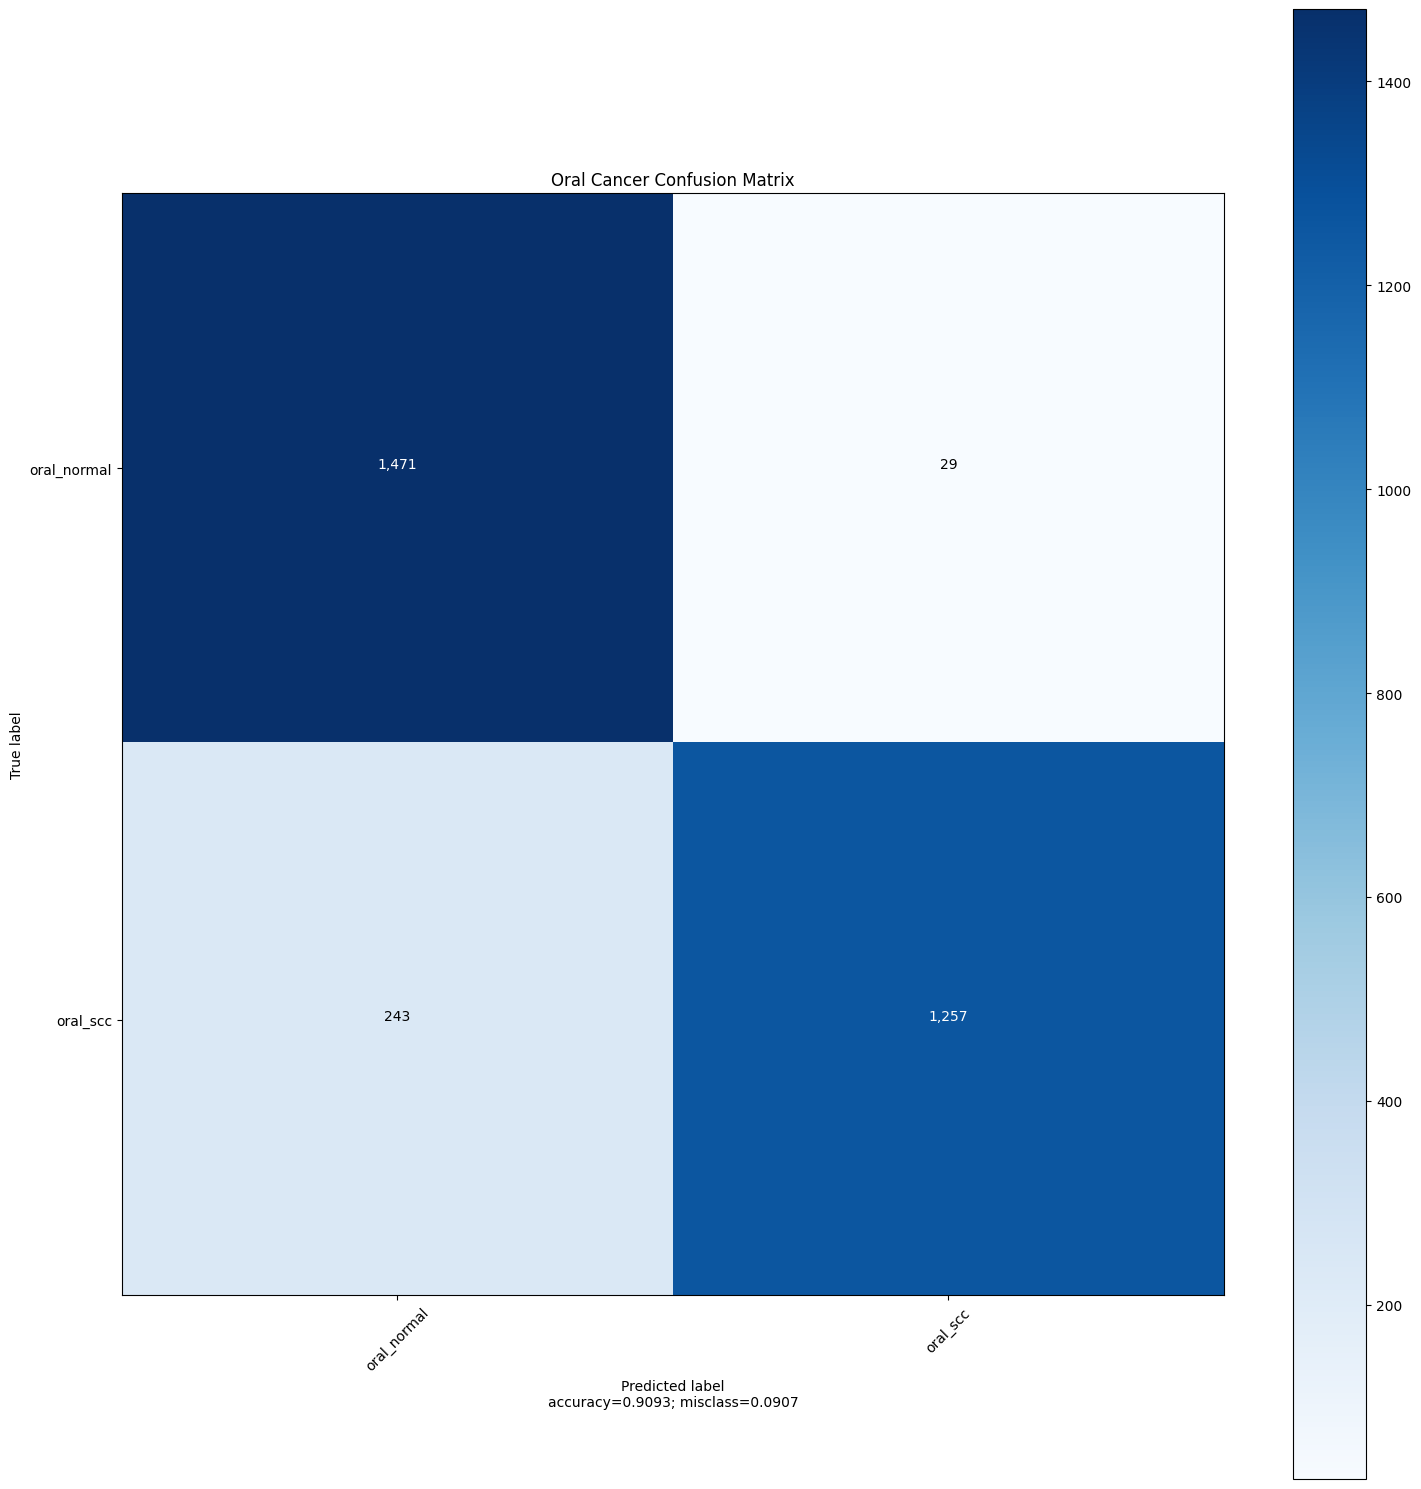

Best Hyperparameters (learning rate, batch size): [9.95285453e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [12]:
className = 'Oral Cancer '
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 14000 images belonging to 4 classes.

For Val :  Found 6000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)    

2024-04-22 12:47:08.637871: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


438/438 [==============================] - ETA: 0s - loss: 0.1076 - tp: 13420.0000 - fp: 446.0000 - tn: 41554.0000 - fn: 580.0000 - precision: 0.9678 - recall: 0.9586 - accuracy: 0.9630 - auc: 0.9978
Epoch 1: val_loss improved from inf to 0.02451, saving model to ALLEfficientNetB0.keras
438/438 [==============================] - 204s 447ms/step - loss: 0.1076 - tp: 13420.0000 - fp: 446.0000 - tn: 41554.0000 - fn: 580.0000 - precision: 0.9678 - recall: 0.9586 - accuracy: 0.9630 - auc: 0.9978 - val_loss: 0.0245 - val_tp: 5951.0000 - val_fp: 41.0000 - val_tn: 17959.0000 - val_fn: 49.0000 - val_precision: 0.9932 - val_recall: 0.9918 - val_accuracy: 0.9927 - val_auc: 0.9998 - lr: 0.0010
Epoch 2/10
438/438 [==============================] - ETA: 0s - loss: 0.0416 - tp: 13792.0000 - fp: 178.0000 - tn: 41822.0000 - fn: 208.0000 - precision: 0.9873 - recall: 0.9851 - accuracy: 0.9861 - auc: 0.9996
Epoch 2: val_loss improved from 0.02451 to 0.01361, saving model to ALLEfficientNetB0.keras
438/43

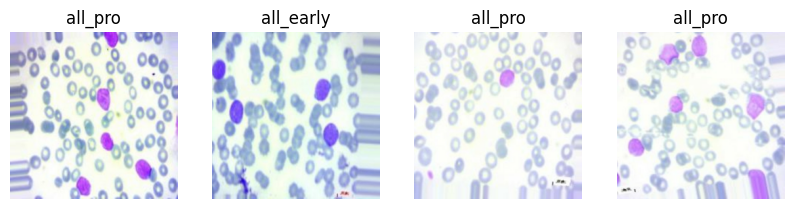

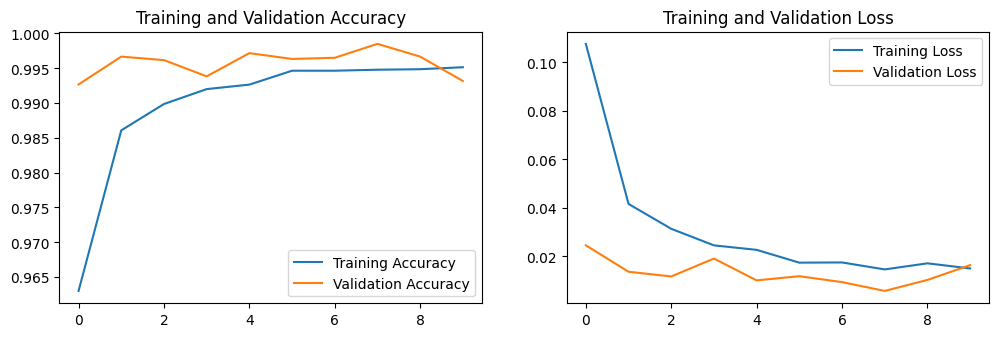

188/188 [==============================] - 19s 99ms/step - loss: 0.0163 - tp: 5958.0000 - fp: 41.0000 - tn: 17959.0000 - fn: 42.0000 - precision: 0.9932 - recall: 0.9930 - accuracy: 0.9932 - auc: 0.9999
Accuracy on the Test Set = 99.32 %
True Positives = 5958.0. True Negatives = 17959.0
False Positives = 41.0. False Negatives = 42.0
Precision = 0.9931655526161194
Recall = 0.9929999709129333
F1 Score = 99.3082754862458
ROC AUC = 0.999947190284729
Model saved at: /kaggle/working/ALL - EfficientNetB0.keras
True :  [0 0 0 ... 3 3 3]
188/188 [==============================] - 19s 94ms/step
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 640x480 with 0 Axes>

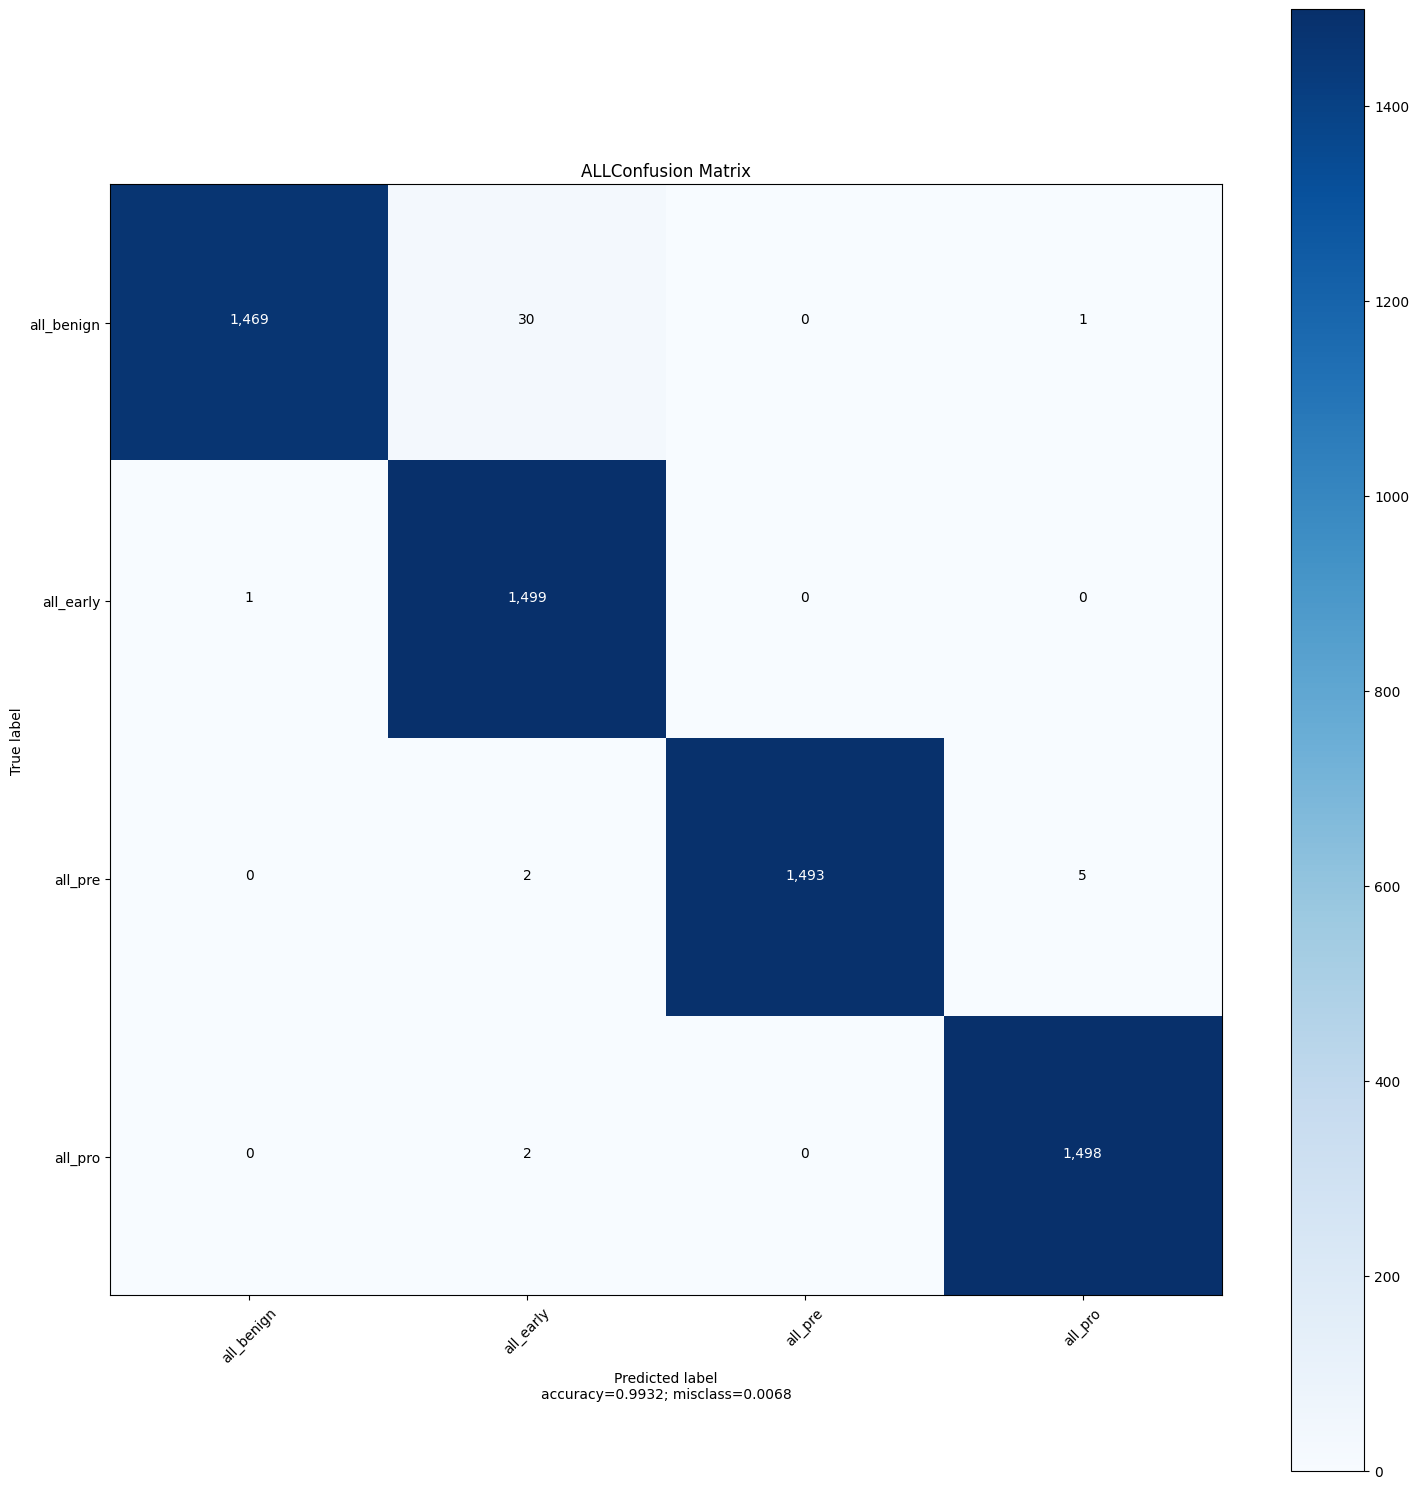

Best Hyperparameters (learning rate, batch size): [9.95285426e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [13]:
className = 'ALL'
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                     

2024-04-22 13:09:23.091047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


219/219 [==============================] - ETA: 0s - loss: 0.0554 - tp: 6870.0000 - fp: 130.0000 - tn: 6870.0000 - fn: 130.0000 - precision: 0.9814 - recall: 0.9814 - accuracy: 0.9814 - auc: 0.9979
Epoch 1: val_loss improved from inf to 0.11258, saving model to Kidney Cancer EfficientNetB0.keras
219/219 [==============================] - 113s 480ms/step - loss: 0.0554 - tp: 6870.0000 - fp: 130.0000 - tn: 6870.0000 - fn: 130.0000 - precision: 0.9814 - recall: 0.9814 - accuracy: 0.9814 - auc: 0.9979 - val_loss: 0.1126 - val_tp: 2865.0000 - val_fp: 135.0000 - val_tn: 2865.0000 - val_fn: 135.0000 - val_precision: 0.9550 - val_recall: 0.9550 - val_accuracy: 0.9550 - val_auc: 0.9925 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0097 - tp: 6985.0000 - fp: 15.0000 - tn: 6985.0000 - fn: 15.0000 - precision: 0.9979 - recall: 0.9979 - accuracy: 0.9979 - auc: 1.0000
Epoch 2: val_loss did not improve from 0.11258
219/219 [==============================] - 29s 

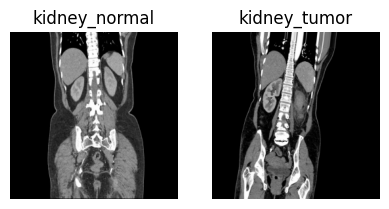

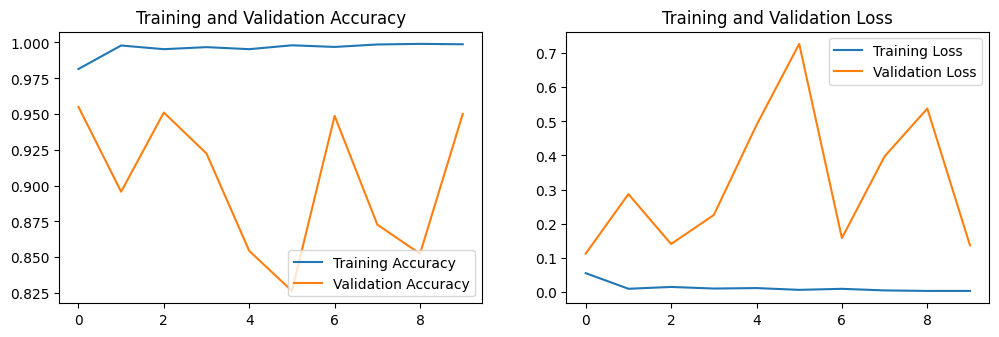

94/94 [==============================] - 9s 91ms/step - loss: 0.1365 - tp: 2850.0000 - fp: 150.0000 - tn: 2850.0000 - fn: 150.0000 - precision: 0.9500 - recall: 0.9500 - accuracy: 0.9500 - auc: 0.9895
Accuracy on the Test Set = 95.00 %
True Positives = 2850.0. True Negatives = 2850.0
False Positives = 150.0. False Negatives = 150.0
Precision = 0.949999988079071
Recall = 0.949999988079071
F1 Score = 94.9999988079071
ROC AUC = 0.9894514083862305
Model saved at: /kaggle/working/Kidney Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 11s 96ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

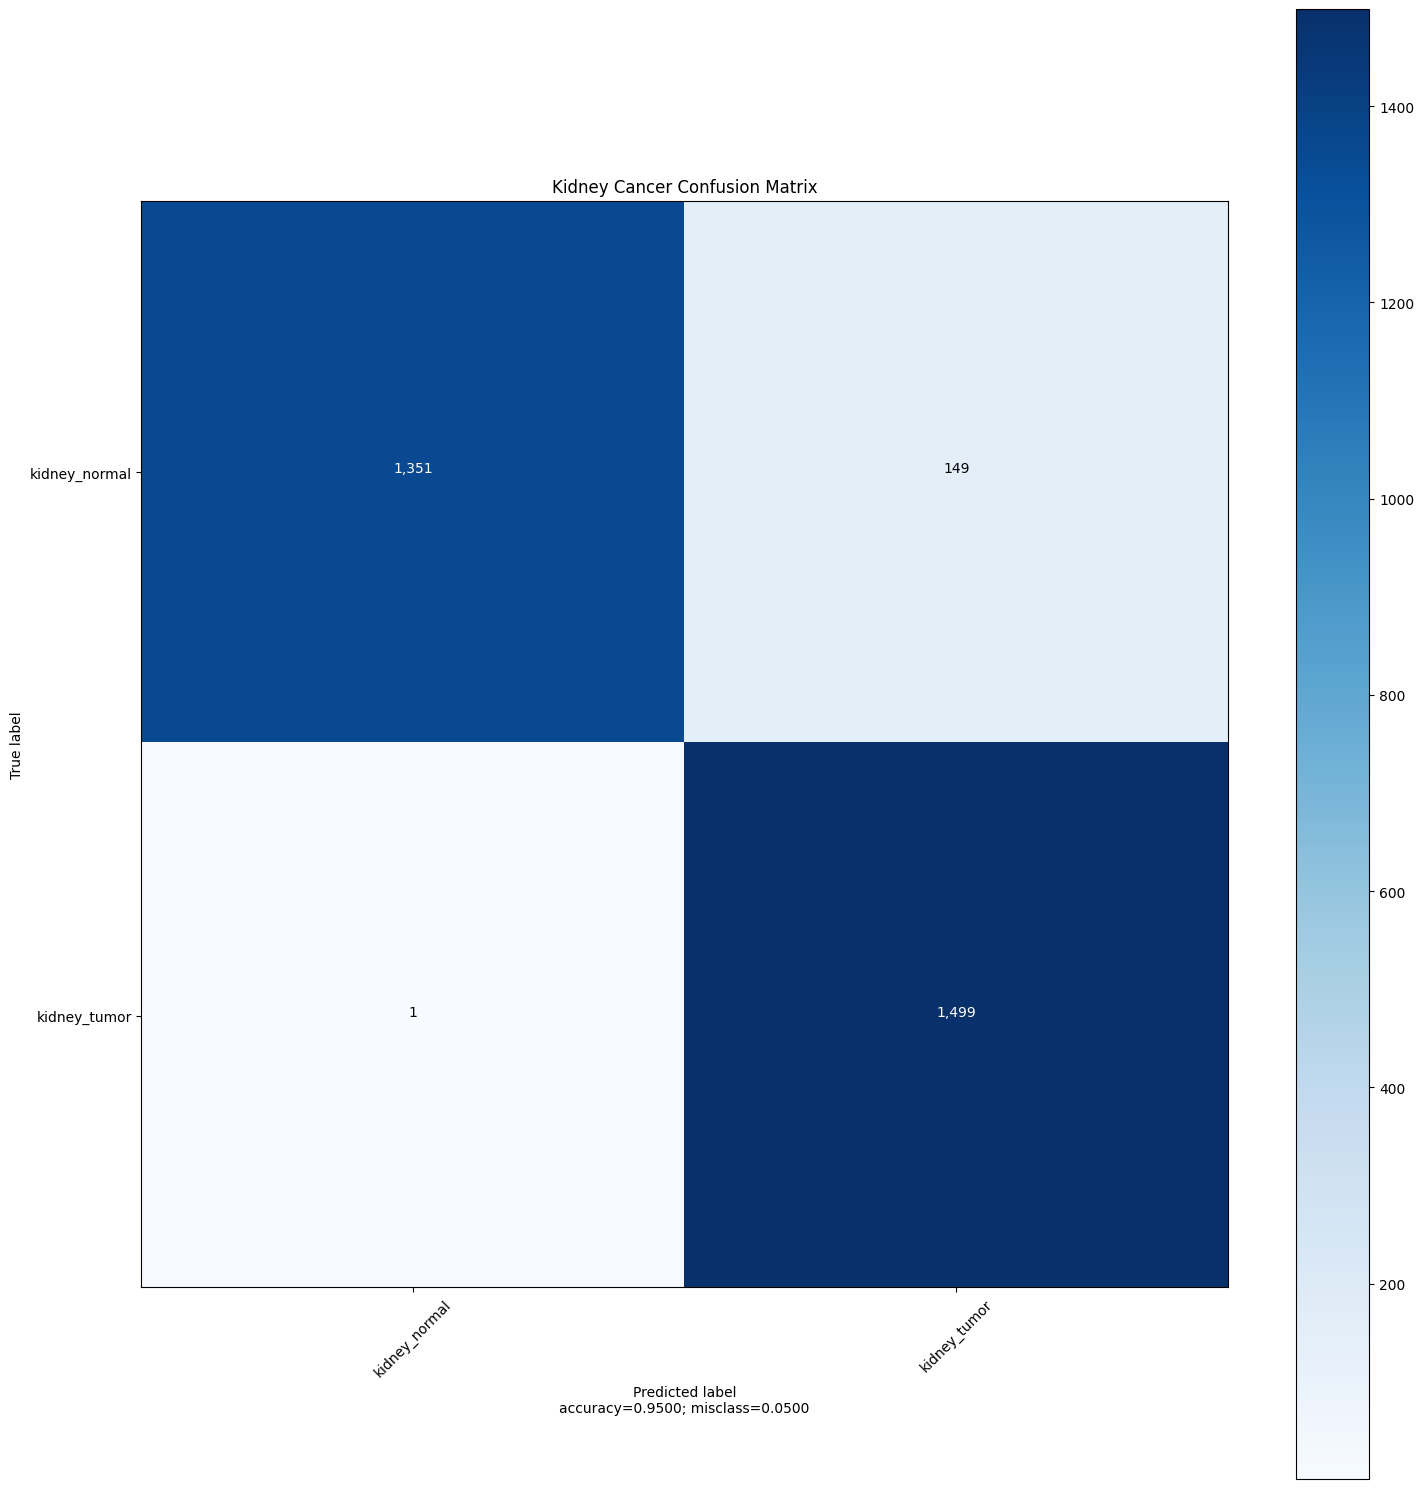

Best Hyperparameters (learning rate, batch size): [9.95284155e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [14]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)                 

2024-04-22 13:20:18.855116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


219/219 [==============================] - ETA: 0s - loss: 0.0823 - tp: 6796.0000 - fp: 204.0000 - tn: 6796.0000 - fn: 204.0000 - precision: 0.9709 - recall: 0.9709 - accuracy: 0.9709 - auc: 0.9949
Epoch 1: val_loss improved from inf to 0.07086, saving model to Breast Cancer EfficientNetB0.keras
219/219 [==============================] - 177s 776ms/step - loss: 0.0823 - tp: 6796.0000 - fp: 204.0000 - tn: 6796.0000 - fn: 204.0000 - precision: 0.9709 - recall: 0.9709 - accuracy: 0.9709 - auc: 0.9949 - val_loss: 0.0709 - val_tp: 2921.0000 - val_fp: 79.0000 - val_tn: 2921.0000 - val_fn: 79.0000 - val_precision: 0.9737 - val_recall: 0.9737 - val_accuracy: 0.9737 - val_auc: 0.9957 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0390 - tp: 6901.0000 - fp: 99.0000 - tn: 6901.0000 - fn: 99.0000 - precision: 0.9859 - recall: 0.9859 - accuracy: 0.9859 - auc: 0.9986
Epoch 2: val_loss improved from 0.07086 to 0.03740, saving model to Breast Cancer EfficientNetB0

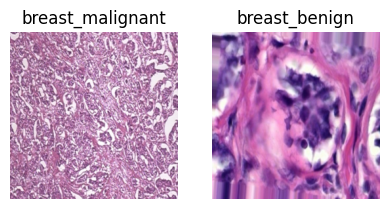

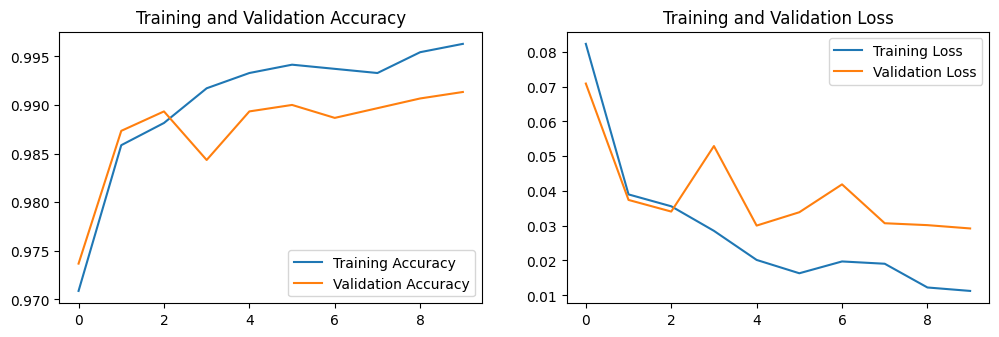

94/94 [==============================] - 21s 228ms/step - loss: 0.0292 - tp: 2974.0000 - fp: 26.0000 - tn: 2974.0000 - fn: 26.0000 - precision: 0.9913 - recall: 0.9913 - accuracy: 0.9913 - auc: 0.9989
Accuracy on the Test Set = 99.13 %
True Positives = 2974.0. True Negatives = 2974.0
False Positives = 26.0. False Negatives = 26.0
Precision = 0.9913333058357239
Recall = 0.9913333058357239
F1 Score = 99.13333058357239
ROC AUC = 0.998909592628479
Model saved at: /kaggle/working/Breast Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 1 1 1]
94/94 [==============================] - 23s 226ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

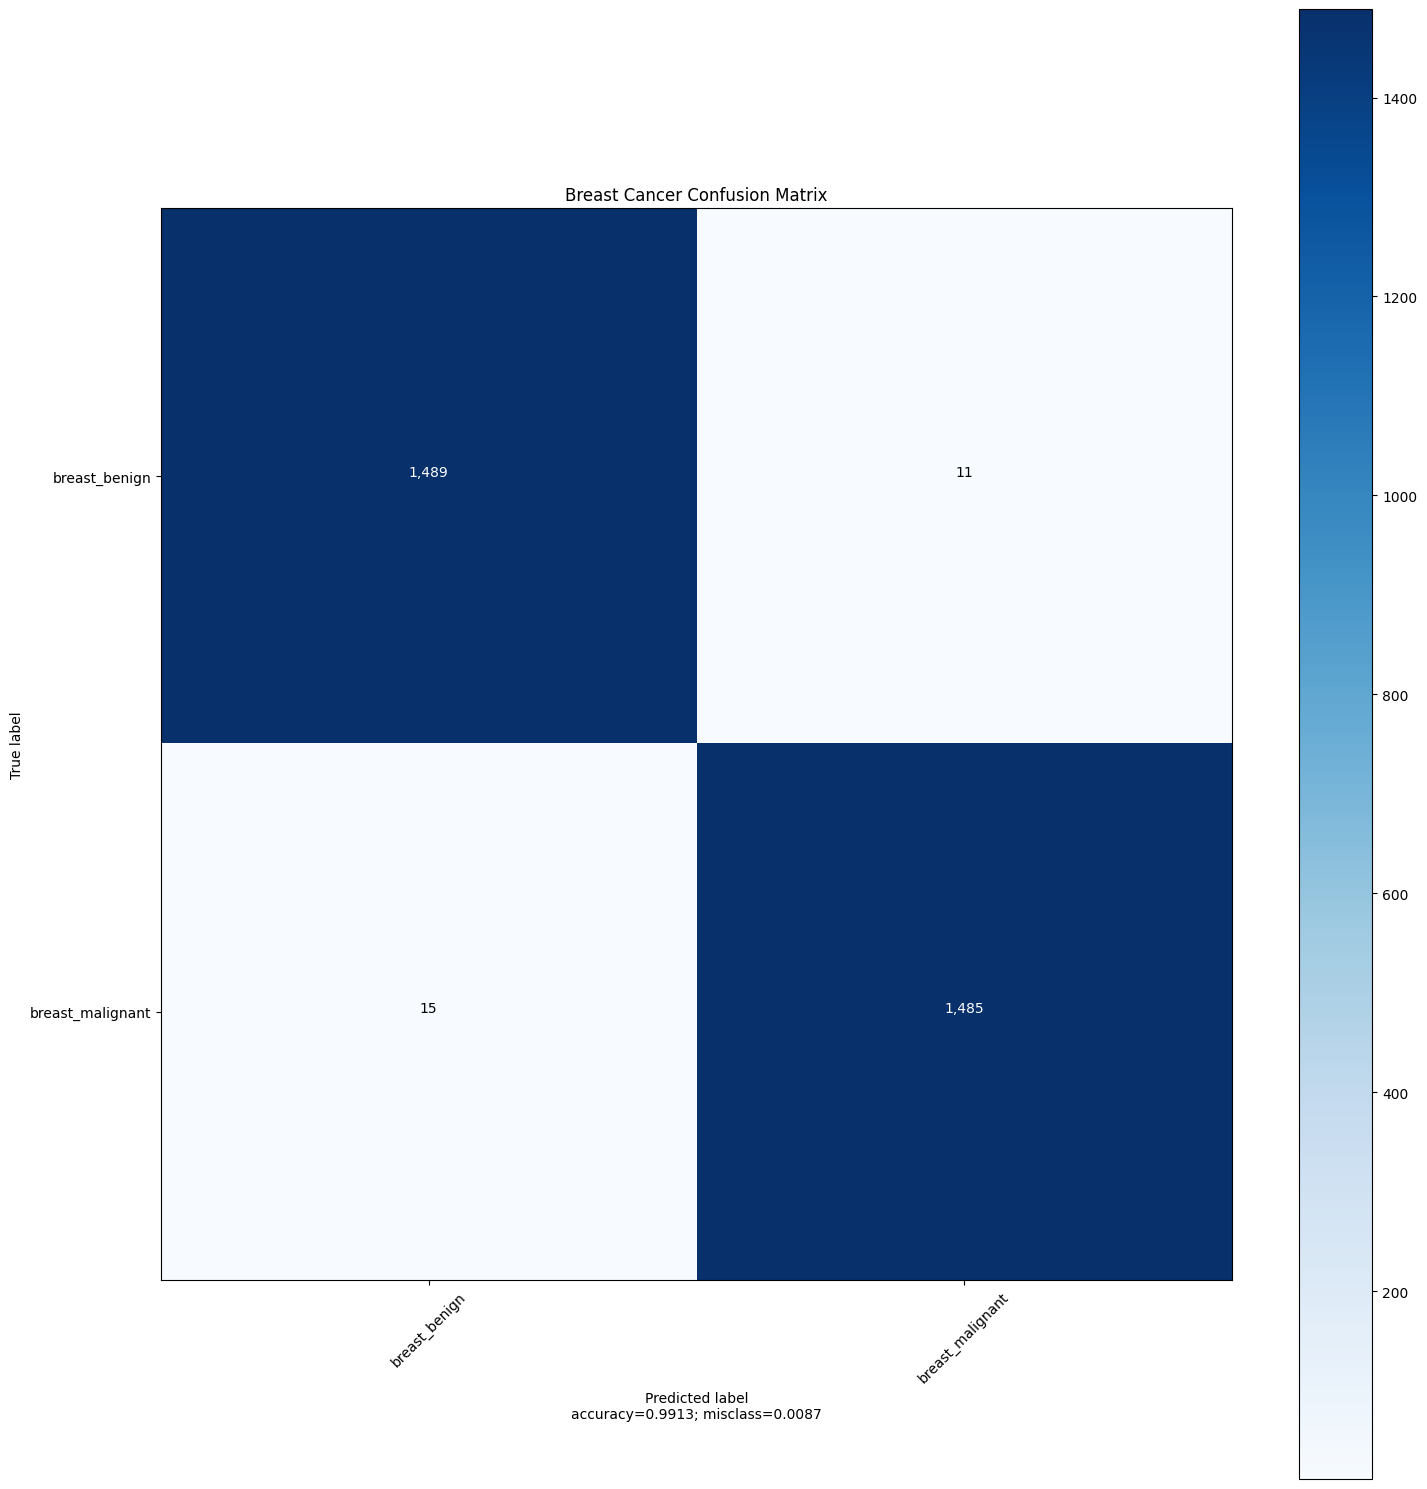

Best Hyperparameters (learning rate, batch size): [9.95284321e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [15]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_8[0][0]']         
 tion)               

2024-04-22 13:39:01.273169: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - ETA: 0s - loss: 0.5958 - tp: 7383.0000 - fp: 2134.0000 - tn: 18866.0000 - fn: 3117.0000 - precision: 0.7758 - recall: 0.7031 - accuracy: 0.7458 - auc: 0.9037
Epoch 1: val_loss improved from inf to 0.53942, saving model to Lymphoma EfficientNetB0.keras
329/329 [==============================] - 192s 560ms/step - loss: 0.5958 - tp: 7383.0000 - fp: 2134.0000 - tn: 18866.0000 - fn: 3117.0000 - precision: 0.7758 - recall: 0.7031 - accuracy: 0.7458 - auc: 0.9037 - val_loss: 0.5394 - val_tp: 3299.0000 - val_fp: 838.0000 - val_tn: 8162.0000 - val_fn: 1201.0000 - val_precision: 0.7974 - val_recall: 0.7331 - val_accuracy: 0.7702 - val_auc: 0.9210 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.3986 - tp: 8654.0000 - fp: 1406.0000 - tn: 19594.0000 - fn: 1846.0000 - precision: 0.8602 - recall: 0.8242 - accuracy: 0.8430 - auc: 0.9567
Epoch 2: val_loss improved from 0.53942 to 0.30199, saving model to Lymphoma EfficientN

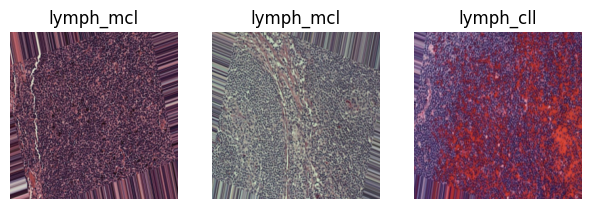

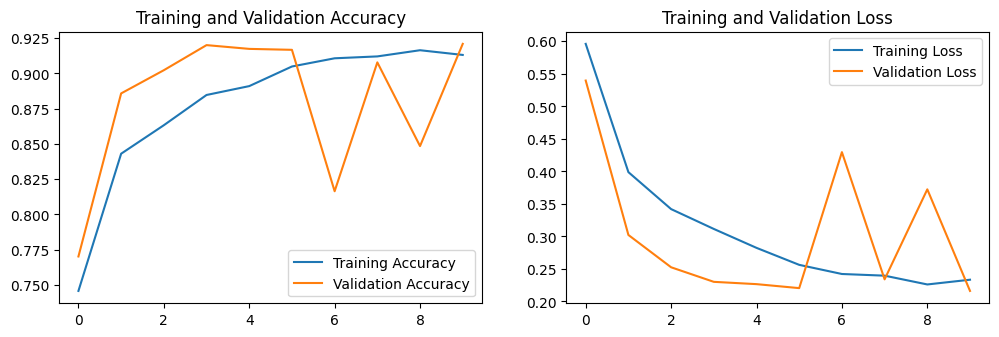

141/141 [==============================] - 17s 121ms/step - loss: 0.2160 - tp: 4089.0000 - fp: 319.0000 - tn: 8681.0000 - fn: 411.0000 - precision: 0.9276 - recall: 0.9087 - accuracy: 0.9209 - auc: 0.9873
Accuracy on the Test Set = 92.09 %
True Positives = 4089.0. True Negatives = 8681.0
False Positives = 319.0. False Negatives = 411.0
Precision = 0.9276315569877625
Recall = 0.9086666703224182
F1 Score = 91.80511810532721
ROC AUC = 0.9872832894325256
Model saved at: /kaggle/working/Lymphoma  - EfficientNetB0.keras
True :  [0 0 0 ... 2 2 2]
141/141 [==============================] - 19s 122ms/step
Predicted :  [0 0 0 ... 2 2 0]


<Figure size 640x480 with 0 Axes>

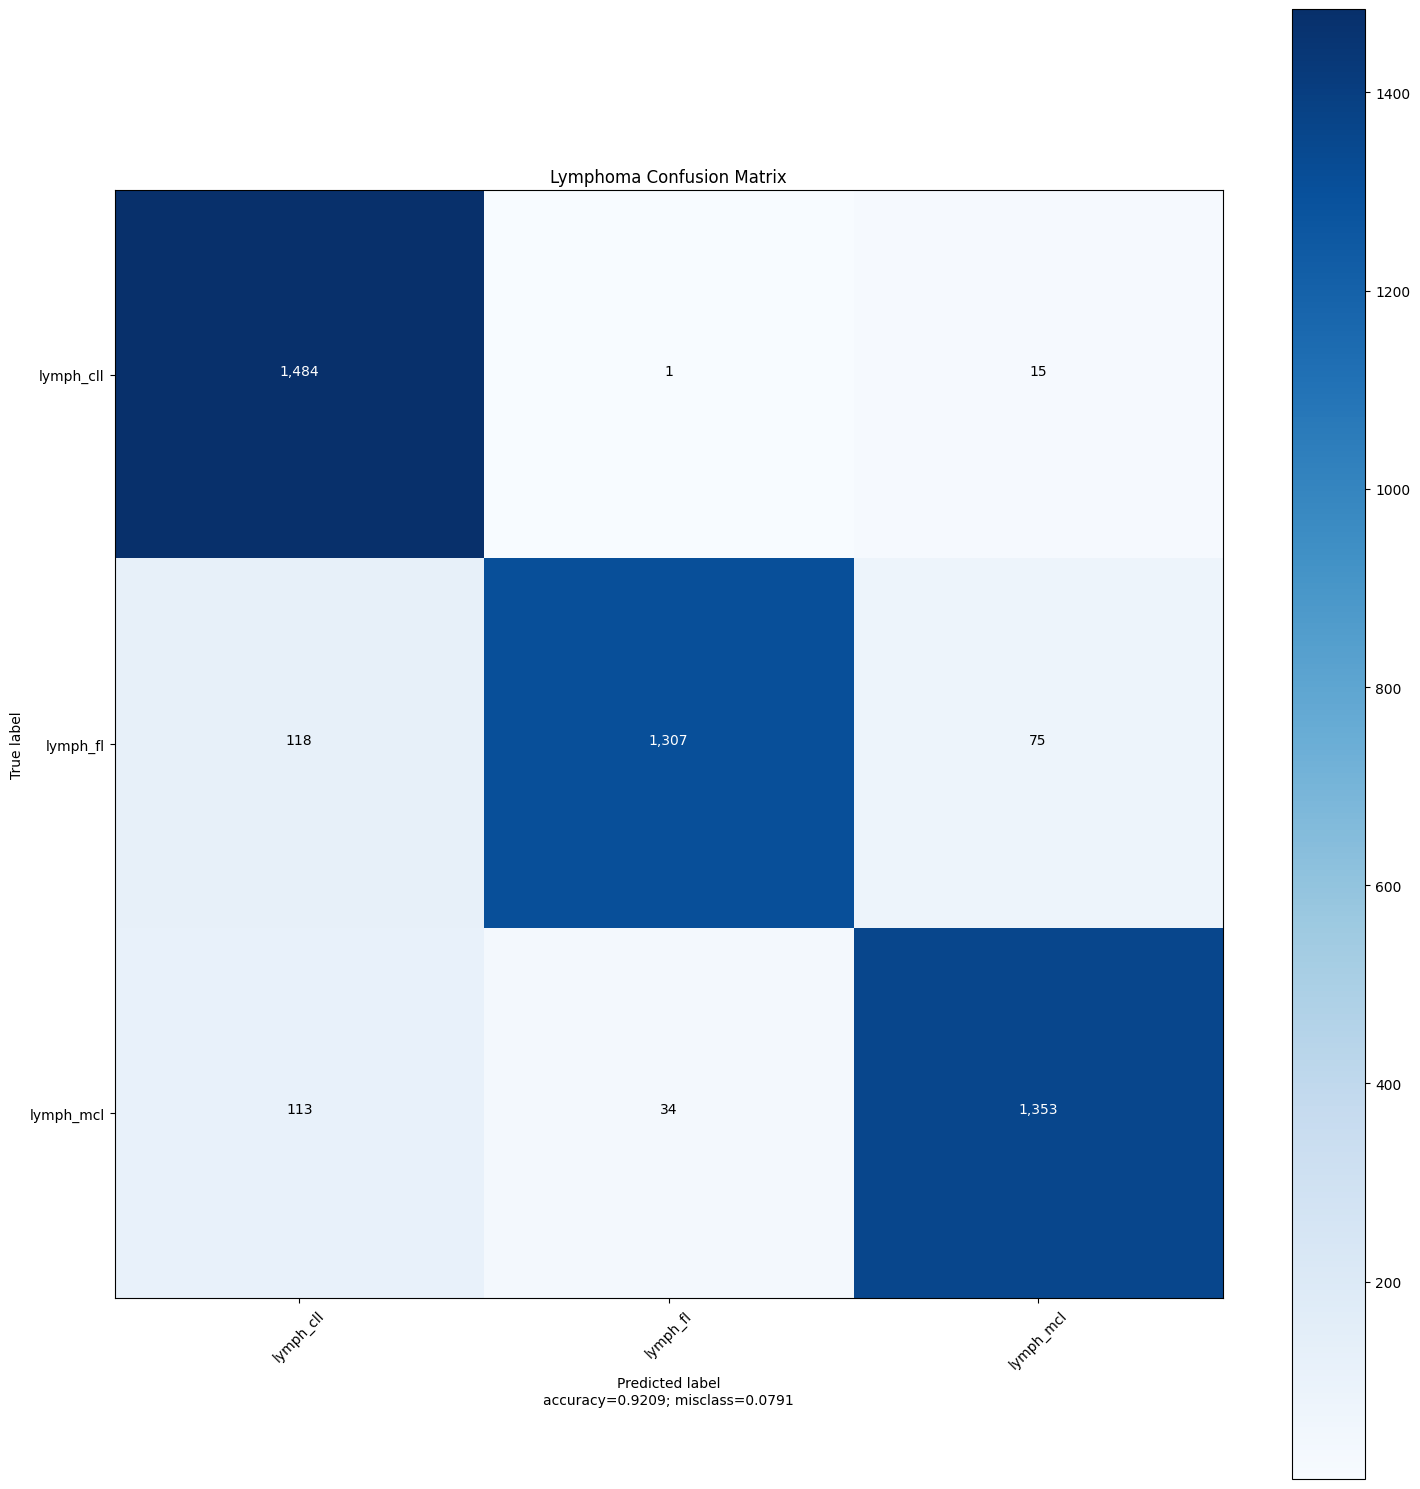

Best Hyperparameters (learning rate, batch size): [9.95285137e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [16]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Val :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_12 (Rescaling)    (None, 224, 224, 3)          0         ['input_7[0][0]']             
                                                                                                  
 normalization_6 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_12[0][0]']        
 tion)       

2024-04-22 14:05:30.527911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - ETA: 0s - loss: 0.2458 - tp: 9487.0000 - fp: 868.0000 - tn: 20132.0000 - fn: 1013.0000 - precision: 0.9162 - recall: 0.9035 - accuracy: 0.9106 - auc: 0.9823
Epoch 1: val_loss improved from inf to 0.17431, saving model to Brain Cancer EfficientNetB0.keras
329/329 [==============================] - 53s 138ms/step - loss: 0.2458 - tp: 9487.0000 - fp: 868.0000 - tn: 20132.0000 - fn: 1013.0000 - precision: 0.9162 - recall: 0.9035 - accuracy: 0.9106 - auc: 0.9823 - val_loss: 0.1743 - val_tp: 4190.0000 - val_fp: 279.0000 - val_tn: 8721.0000 - val_fn: 310.0000 - val_precision: 0.9376 - val_recall: 0.9311 - val_accuracy: 0.9353 - val_auc: 0.9912 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.1325 - tp: 9948.0000 - fp: 493.0000 - tn: 20507.0000 - fn: 552.0000 - precision: 0.9528 - recall: 0.9474 - accuracy: 0.9499 - auc: 0.9947
Epoch 2: val_loss improved from 0.17431 to 0.09324, saving model to Brain Cancer Efficien

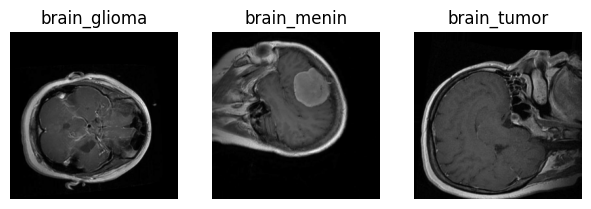

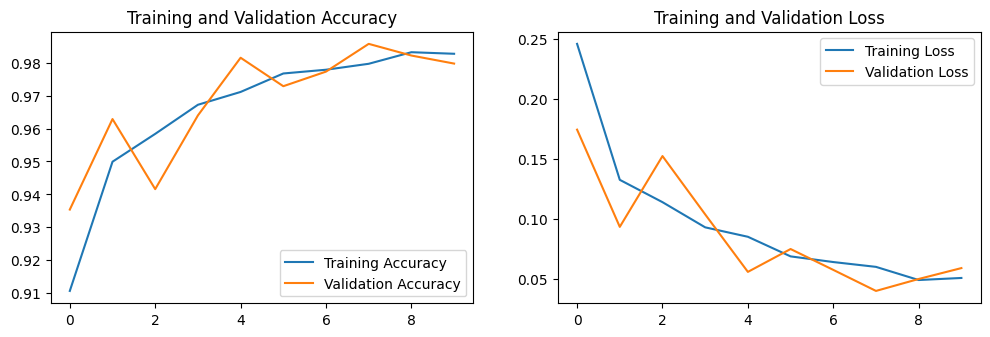

141/141 [==============================] - 13s 93ms/step - loss: 0.0589 - tp: 4407.0000 - fp: 89.0000 - tn: 8911.0000 - fn: 93.0000 - precision: 0.9802 - recall: 0.9793 - accuracy: 0.9798 - auc: 0.9984
Accuracy on the Test Set = 97.98 %
True Positives = 4407.0. True Negatives = 8911.0
False Positives = 89.0. False Negatives = 93.0
Precision = 0.9802046418190002
Recall = 0.9793333411216736
F1 Score = 97.97687977601583
ROC AUC = 0.998401939868927
Model saved at: /kaggle/working/Brain Cancer  - EfficientNetB0.keras
True :  [0 0 0 ... 2 2 2]
141/141 [==============================] - 15s 95ms/step
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 640x480 with 0 Axes>

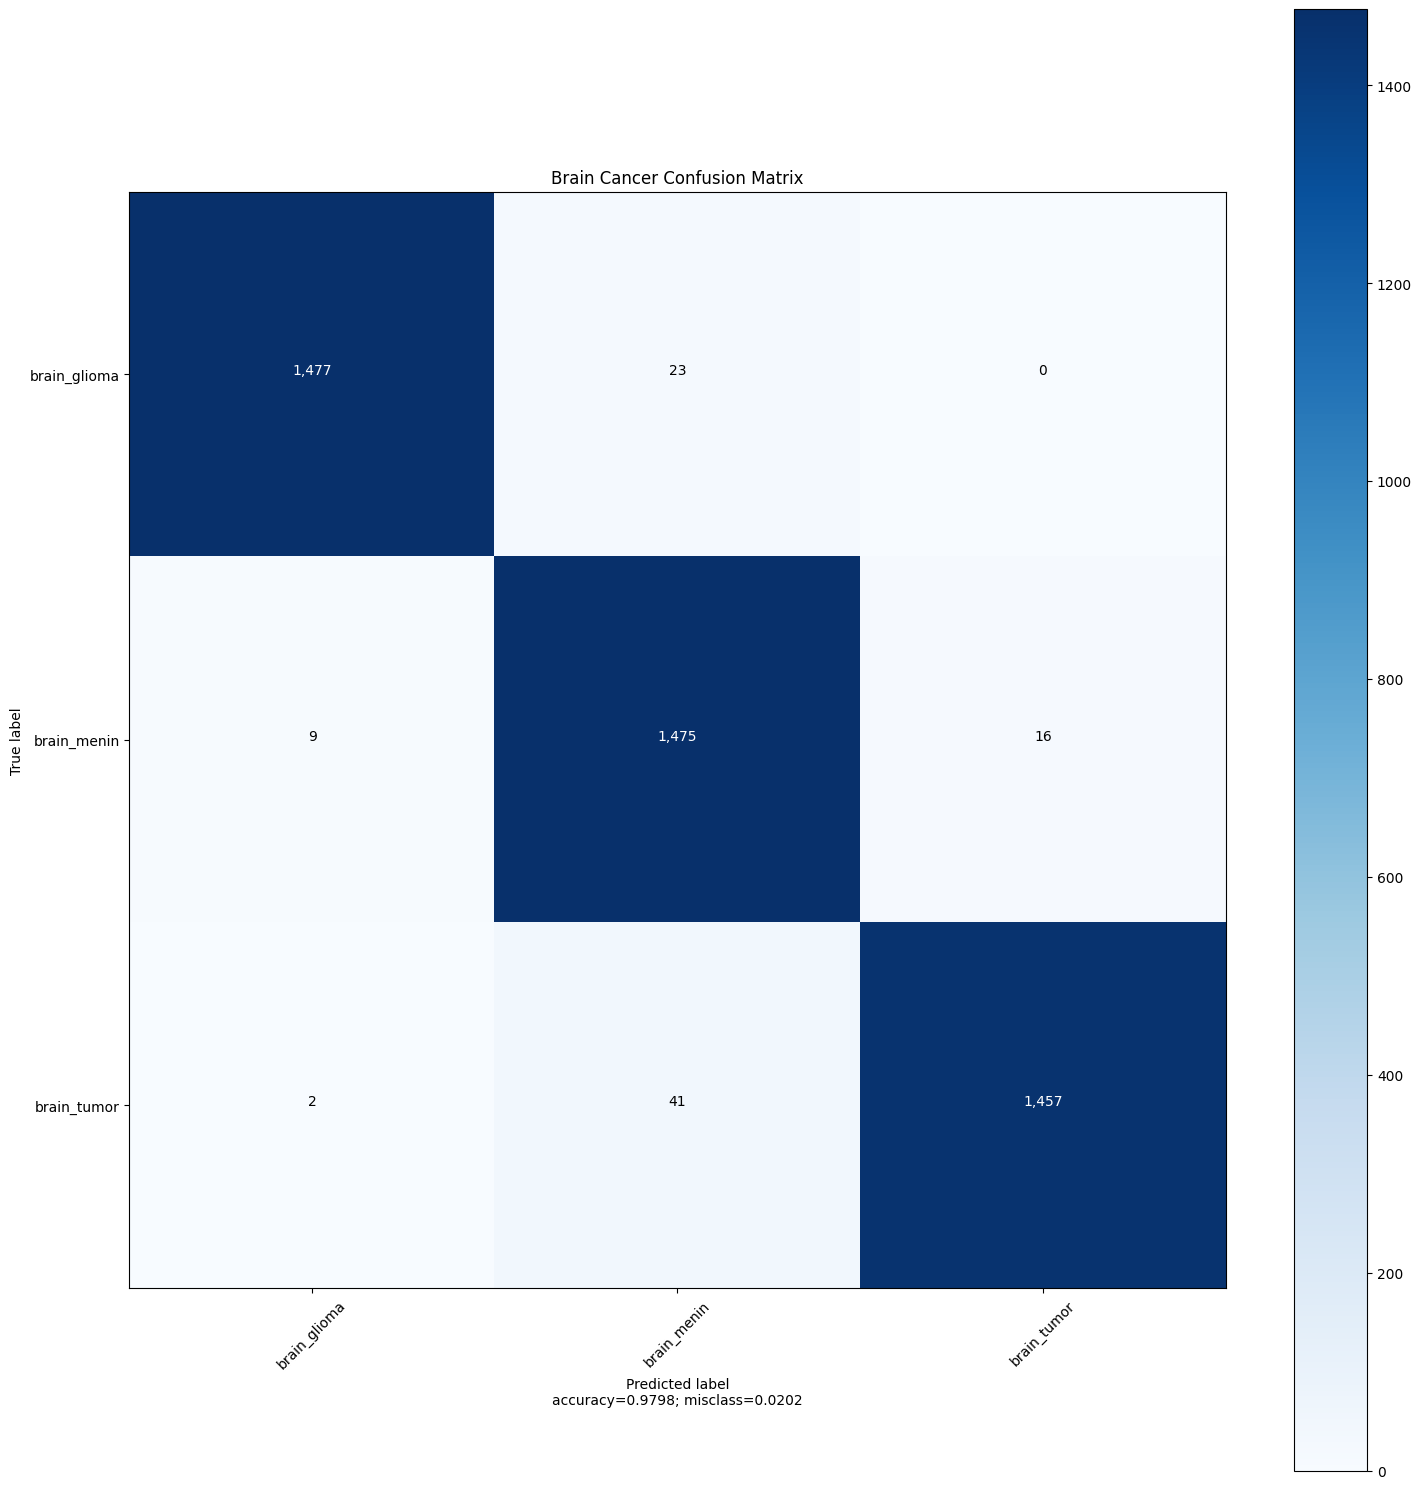

Best Hyperparameters (learning rate, batch size): [9.95284956e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [18]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)